# Predictive Maintenance

### Author: Felipe Marcelino

### Context

In this assignment, you will analyze sensor data from a critical piece of equipment aboard an Floating Production, Storage, and Offloading (FPSO) vessel. FPSOs are pivotal in offshore oil and gas operations. Ensuring the reliability of onboard equipment is essential to prevent operational disruptions, safety risks, and costly downtime.

### Data 

The dataset contains anonymized time series records of a machine's operation from an FPSO. The recorded variables are as follows:

**Cycle**: Sequential identifier of measurement cycles. <br>
**Preset_1** & **Preset_2**: Variables that control a specific operating point of the machine. <br>
**Temperature**: Temperature recorded in the equipment. <br>
**Vibrations (X, Y & Z)**: Vibrations along the machine's axes. <br>
**Frequency**: Operating frequency of the machine. <br>
**Fail**: Variable indicating whether the machine is in a failure state at the given timestamp. <br>

 Ther are in total of 800 rows varying each one of the presets with the respectives values for **temperature**, **vibrations**, **frequency** and the label **fail**. Dataset does not contain any null values on the columns

**Fail Rate** is 8,25%

### Methdology 

The following sentences are the steps applied on the problem:
- Dataset summary: Statistical summaries (mean, percentiles, etc) were computed to indentify distribution, outliers, and imbalance.
- Visual Analysis
    - Univarite: Histograms/boxplots for variables like temperature and vibration to detect skewness or anomalie
    - Bivariate: Heatmap, lineplot, boxplots to explore relationships between features and the target (Fail)
- Feature Engineering:
    - Temporal Features:
        - Rolling Statistics: Computed rolling means/standard deviations
        - Lag Features: Past values to model temporal dependencies
    - Vibration Magnitude: Aggregate mutli-axis vibrations into a single metric
    - Target Encoding: Time-aware encoding for categorical presets to avoid data leakage
- Create plots to get insights about univariate and bivariate analysis
- Modeling:
    - Train/test Split: Sequential split (no shuffling) to respect time-series integrity. For example, cycles 1–640 for training, 641–800 for testing.
    - Algorithm: LightGBM was chosen for its speed and efficiency with temporal data
    - PR-AUC was selected because of imbalanced dataset for positive class. In addition, we want to control threshold to manipulate false positive and false negative
- Forecast Horizon:
    - Testing 3/5/10-cycle predictions and see which one has better trade-off between metrics.
- Teste model inference time
    - Create a synthetic batch dataset a simulate inference time for the batch and average for one sample.
- Interpretability:
   - SHAP Values:  Used to calculate the feature importance performance
 
### Classification Approach

The model create here predict in C cycles (predict the future) if maintanence is a necessity of not. For example: in the exact next C cycles what is the label value (True or False), using C equal to 2:

| cycle | temperature | ... | fail | future_fail |
|------:|------------:|-----|-------|-------------|
| 1 | 80 | … | False | True |
| 2 | 94 | … | False | False |
| 3 | 92 | … | True | False |
| 4 | 84 | … | False | True |

Cycle 1 takes label from cycle 3, cycle 2 from cycle 4, cycle 3 from cycle 5 and so on. Three diferent values for C were tested: 3, 5 and 10.

### Features Logic

#### Rolling Feautures

Aggregated statistics using rolling averages/std/average smooth transient fluctuations to reveal trends. Trend detection for example is related to gradual degrdation which is easy detectable than using raw point-in-time data. Machines often fail due to cumulative stress

#### Lag Features

Machine behavior often evolves gradually. Lagged values capture delayed effects, for example, a spike in vibration today might correlated with a failure 3 days later. Failures rarely occur instantanneously; they are often precced by anomalies in prior cycles

#### Vibration Magnitude
Vibration seems to have a high correlation with the target variable and other variables as well. In other words, vibrations is a good signal regarding failure. High value value of vibration more signal to failure

#### Target Encoding

Use one-hot encoding is not a good option here, so target encoding show how much of the settings is related to failure here. The high the chances of settings is related to failure high its feature value, which will be a good separation used by the model.


### Conclusion 

The model achieves the PR-AUC of 0.72 and AUC-ROC of 0.917. The time series regarding the temperature, vibrations and frequency seems to be stationary without trend an seazonal features. The most correlated feature with the target (Fail) is VibrationY, howerver, the most important features for the model are rolling and lag features. The model used here to train and test the dataset is LightGBM because of it faster iteration on training and inference. Related to predict the future, we tested three values, predict 3,5,10 cycles ahead of the current time. The best one is 3 cycles, more closer to the future but without too much time to act. Model inference time is approximately 1 

## Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import shap
import warnings
import timeit
import optuna 
from typing import Union
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Variables

In [3]:
FEATURES: list = ['Temperature', 'Pressure', 'VibrationX',  'VibrationY', 'VibrationZ', 'Frequency'] # Raw features
PRESETS: list = ['Preset_1','Preset_2'] # Operation settings
TARGET: str = 'Fail' # Target variable 
TIMESTAMP: str = 'Cycle' # Timestamp column 
WINDOWS_SIZE_ROLLING: list = [3, 7, 10] # Modify WINDOWS_MIN_PERIOD as well. They have the same length. Can be tuned
WINDOWS_MIN_PERIOD: list = [None, None, None] # Minimum period to calculate windows function. Can be tuned
WINDOWS_SIZE_LAG: list = [1,2,3,5] # Number of lag features. Can be tuned 
FUTURE_TARGET: str = 'Fail_Future' # Future target used to train the model 
BATCH_INFERENCE_SIZE: int = 10000 # Used to test model inference time 
C: int = 3 # How much cycles in the future we want predict our target. Can be tuned
TEST_SIZE: float = 0.2 # The test size used to validation 
THRESHOLD: float = 0.10 # Threshold related to output of the model. Will be 1 if >= threshold. Can be tuned
PRESET_LAG: bool = True # Create preset lag features or not
SEED: int = 42 # Seed used to on randomness part
EARLY_STOPPING: int = 100 # Early stopping used on train phase on lightgbm algorithm
N_TRIALS: int = 300 # Optuna N trials for hyperparamter search 
DEFAULT_LGB_PARAMETERS: dict = {   # Default settings for lightgbm algorithm 
    'n_estimators':  10000, # High value that EARLY_STOPPING will take into account when stopping will be needed
    'random_state':   SEED,
    'objective':   'binary',
    'metric':  'average_precision',
    'boosting_type':   'gbdt',
    'njobs':   -1,
}

## Definitions

In [4]:
def create_rolling_feature(df: pd.DataFrame, column: str, func: str, window_size: int, min_periods: int = None):
    """
    Create rolling mean/std features in a pandas DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    column (str): Column name to calculate rolling features from
    func (str): 'mean' or 'std' for rolling statistic
    window_size (int): Size of the rolling window
    min_periods (int): minimum periods for windows rolling
    
    Returns:
    pd.DataFrame: DataFrame with new rolling feature column
    
    """
    
    # Input validation
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    if func not in ['mean', 'std', 'var']:
        raise ValueError("Function must be 'mean', 'std' or 'var'")
    if not isinstance(window_size, int) or window_size <= 0:
        raise ValueError("Window size must be a positive integer")


    new_col = f"{column}_rolling_{func}_{window_size}"
    
    # Calculate rolling feature
    if func == 'mean':
        df[new_col] = df[column].rolling(window=window_size, min_periods=min_periods).mean()
    elif func == 'std':
        df[new_col] = df[column].rolling(window=window_size, min_periods=min_periods).std()
    else:
        df[new_col] = df[column].rolling(window=window_size, min_periods=min_periods).var()
        
    return df

def create_lag_feature(df: pd.DataFrame, column: str, lag_size: int = 1, fill_value: Union[int,float] = None, groupby: str = None):
    """
    Create lag features with optional groupby functionality
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    column (str): Column name to create lag from
    lag_size (int): Number of periods to shift (default: 1)
    fill_value: Value to use for missing values (default: NaN)
    groupby (list/str): Column(s) to group by for group-specific lags
    
    Returns:
    pd.DataFrame: DataFrame with new lag feature column
    """
    
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    if not isinstance(lag_size, int) or lag_size <= 0:
        raise ValueError("Lag size must be a positive integer")
    if groupby is not None:
        groupby = [groupby] if isinstance(groupby, str) else groupby
        missing = [col for col in groupby if col not in df.columns]
        if missing:
            raise ValueError(f"Groupby columns {missing} not found in DataFrame")

    group_suffix = f"_by_{'_'.join(groupby)}" if groupby else ""
    new_col = f"{column}_lag_{lag_size}{group_suffix}"
    
    # Create lag feature
    if groupby:
        # Group-specific lag
        df[new_col] = df.groupby(groupby)[column].shift(lag_size)
    else:
        # Global lag
        df[new_col] = df[column].shift(lag_size, fill_value=fill_value)
    
    # Handle fill value if specified
    if fill_value is not None:
        df[new_col] = df[new_col].fillna(fill_value)
    
    return df

def time_aware_target_encoding(df: pd.DataFrame, column: str):
    """
    Create time aware target features. It uses on the first N values to create target encoding.
    In that way it avoid data leakage using feature values to encoding the past.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame
    column (str): Column name to create target encoding
    
    Returns:
    pd.DataFrame: DataFrame with new lag feature column
    """    

    new_column = f"{column}_target_encoded"

    df[new_column] = (
    df.groupby(column)[TARGET]
    .expanding(min_periods=1)  
    .mean()
    .shift(1)  # Exclude current row to prevent leakage
    .reset_index(drop=True))

    return df 

In [5]:
def lgb_train_test(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.2, params: dict = None, 
                   threshold: float = 0.5, early_stopping: int = 50):
    """
    Train/test procedure for LightGBM classification with PR-AUC evaluation
    
    Parameters:
    model (Object): A model to train
    X (pd.DataFrame): Features dataframe
    y (pd.Series): Target variable
    columns (list): Columns list to train the model
    test_size (float): Proportion of data for testing (default: 0.2)
    params (dict): LightGBM parameters (optional)
    threshold (float): Threshold for the output
    early_stopping (int): Early stopping procedure steps
    
    Returns:
    tuple: (model, test_preds, X_train, y_train, X_test, y_test, metrics_dict)
    """

     # Train-test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED, shuffle=False)
    
    # Create LightGBM datasets
    # Use Dataset directly from numpy arrays to avoid pandas issues
    train_data = lgb.Dataset(X_train.values if isinstance(X_train, pd.DataFrame) else X_train, 
                           label=y_train.values if isinstance(y_train, pd.Series) else y_train)
    
    test_data  = lgb.Dataset(X_test.values if isinstance(X_test, pd.DataFrame) else X_test,
                           label=y_test.values if isinstance(y_test, pd.Series) else y_test,
                           reference=train_data)
    
    # Train model with early stopping
    model = lgb.train(
        params,
        train_set=train_data,
        valid_sets=[test_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=early_stopping),
            lgb.log_evaluation(False)
        ]
    )
    
    # Get best iteration predictions
    y_pred = model.predict(X_test.values if isinstance(X_test, pd.DataFrame) else X_test, 
                         num_iteration=model.best_iteration)

    # Binarizying output probability based on threshold 
    test_preds_class = (y_pred >= threshold).astype(int)

    
    # Calculate metrics
    #------------------
    # Calculate PR-AUC
    pr_auc = average_precision_score(y_test, y_pred)
    # Calculate precision and recall for curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    # Calculate Accuracy
    acc = accuracy_score(y_test, test_preds_class)
    # Calculate Confusion Matrix
    conf_matrix = confusion_matrix(y_test, test_preds_class)

    lgb.Booster.save_model(model, "booster.txt")
    
    metrics_dict = {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
        'accuracy': acc,
        'confusion_matrix': conf_matrix,
    }
    
    return model, y_pred, X_train, y_train, X_test, y_test, metrics_dict

def objective_lgb_optuna(trial: optuna.trial.Trial , X: pd.DataFrame, y: pd.DataFrame, test_size: float  = 0.2, early_stopping: int = 50):
    """
    Objective optuna function for lightgbm model 

    Paramters:
    trial (optuna.trial.Trial): Hyperparamter trial 
    X (pd.DataFrame): Pandas dataframe containing features 
    y (pd.DataFrame): Pandas dataframe containing labels 
    test_size (float): Float indicating test_size proportion
    early_stopping (int): Early stopping procedure steps

    Returns:
    float: A metric chosen to maximize or minimize the value
    
    """
    
    param_grid = {
        'objective': 'binary',
        'metric': 'average_precision',  # Explicitly optimize for PR-AUC
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Log scale
        'num_leaves': trial.suggest_int('num_leaves', 7, 255, step=2),  # Reduced range
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200, step=10),
        'reg_alpha': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'subsample': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'n_estimators': 10000,  
        'random_state': SEED,
        'verbose': -1,
        'n_jobs': -1
    }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=SEED, 
        shuffle = False,
    )

    # Use Dataset directly from numpy arrays to avoid pandas issues
    train_data = lgb.Dataset(X_train.values if isinstance(X_train, pd.DataFrame) else X_train, 
                           label=y_train.values if isinstance(y_train, pd.Series) else y_train)
    
    test_data = lgb.Dataset(X_test.values if isinstance(X_test, pd.DataFrame) else X_test,
                           label=y_test.values if isinstance(y_test, pd.Series) else y_test,
                           reference=train_data)


    model = lgb.train(
        param_grid,
        train_data,
        valid_sets=[test_data],  
        callbacks=[
            lgb.early_stopping(stopping_rounds=early_stopping),  # More patience
            lgb.log_evaluation(False)  # Disable logging
        ]
    )

    # Get best iteration predictions
    y_pred = model.predict(X_test.values if isinstance(X_test, pd.DataFrame) else X_test, 
                         num_iteration=model.best_iteration)
    
    return average_precision_score(y_test, y_pred)

In [6]:
def test_model_inference_time(total_columns: int, batch_inference_size: int):
    """
    Test model inference time for batch samples and one singular sample

    total_columns (int): Total of columns used to train the model 
    batch_inference_size (int): Total of synthetic samples to be generated
    """
    n_repeats = 100  # Number of prediction runs to average

    model_inf = lgb.Booster(model_file='booster.txt')

    X_test = np.random.rand(batch_inference_size, total_columns)  

    _ = model_inf.predict(X_test)  # Warm-up run (discard timing)
    
    # Time the predictions over multiple runs
    total_time = timeit.timeit(
        stmt='model.predict(X_test)', 
        globals={'model': model_inf, 'X_test': X_test}, 
        number=n_repeats
    )

    # Calculate average time per batch and per sample
    avg_time_per_batch = total_time / n_repeats
    avg_time_per_sample = avg_time_per_batch / X_test.shape[0]
    
    print(f"Average time per batch ({batch_inference_size} samples): {avg_time_per_batch:.6f} seconds")
    print(f"Average time per sample: {avg_time_per_sample:.6f} seconds")

In [7]:
def create_features(df: pd.DataFrame, preset_lag: bool = True):
    """
    Create features to feed the model 

    Parameters:
    df (pd.Dataframe): Data that will be use to create features
    preset_lag: Create preset lag features or not

    Returns 
    pd.DataFrame: Dataframe with newly created features  
    """
    
    # Rolling Features
    for feature in FEATURES:
        for windows_size, min_period in zip(WINDOWS_SIZE_ROLLING, WINDOWS_MIN_PERIOD):
            df = create_rolling_feature(data, feature, 'mean', windows_size, min_period)
            df = create_rolling_feature(data, feature, 'std', windows_size, min_period)
            df = create_rolling_feature(data, feature, 'var', windows_size, min_period)
    
    # Lag Features
    for feature in FEATURES:
        for windows_size in WINDOWS_SIZE_LAG:
            df = create_lag_feature(data, feature, windows_size, None, None)
            if preset_lag:
                df = create_lag_feature(data, feature, windows_size, None, 'Preset_1')
                df = create_lag_feature(data, feature, windows_size, None, 'Preset_2')
                
    # Time aware encoding targe features
    df = time_aware_target_encoding(data, 'Preset_1')
    df = time_aware_target_encoding(data, 'Preset_2')

    # Vibration magnitude
    df['Vibration_Magnitude'] = (data[['VibrationX', 'VibrationY', 'VibrationZ']].pow(2).sum(axis=1)).pow(0.5)

    return df 

In [8]:
def plot_roc_with_auc(metrics_dict: dict, figsize: tuple = (10, 6), fontsize: int = 12):
    """
    Plot ROC curve with ROC-AUC score displayed below the curve
    
    Parameters:
    metrics_dict (dict): Dictionary with metrics 
    figsize (tuple): Figure dimensions
    fontsize (int): Text font size
    """
    
    # Create figure with custom layout
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(bottom=0.25)  # Make space for text below
    
    # Plot ROC curve
    plt.plot(metrics_dict['fpr'], metrics_dict['tpr'], color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {metrics_dict['roc_auc']:.3f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    plt.title('Receiver Operating Characteristic (ROC) Curve', 
              fontsize=fontsize+2, pad=20)
    plt.legend(loc='lower right', fontsize=fontsize)

def plot_pr_curve(metrics_dict: dict, y_test: np.ndarray,  fig_size: tuple = (10,6), fontsize: int = 12):
    """
    Plot Precision-Recall curve with PR-AUC
    
    Parameters:
    metrics_dict (dict): Dictionary containing 'precision', 'recall', and 'pr_auc'
    y_test: (array): Array containing true values used for testing the model
    title (str): Plot title
    fig_size (tuple): Figure size for plots
    fontsize (int): Font size for plots
    """
    
    plt.figure(figsize=fig_size)
    plt.plot(metrics_dict['recall'], metrics_dict['precision'], 
             color='orange', lw=2, 
             label=f'PR Curve (AUC = {metrics_dict["pr_auc"]:.3f})')
    
    # Baseline (random classifier)
    baseline = np.mean(y_test)
    plt.axhline(y=baseline, color='red', linestyle='--', 
                label='Baseline (Random)')
    
    plt.xlabel('Recall', fontsize=fontsize)
    plt.ylabel('Precision', fontsize=fontsize)
    plt.title('Precision-Recall Curve', fontsize=fontsize + 2)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.grid(alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()


def plot_confusion_matrix(metrics_dict: dict, fig_size: tuple = (8,6), fontsize: int = 12):
    """
    Create a confusion matrix using heatmap

    Parameters:
    metrics_dict (dict): Dictionary containing the metrics for confusion matrix (FP, TP, FN, TN)
    fig_size (tuple): Figure fize for plots
    fontsize (int): Font size for plots 
    """
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    sns.heatmap(metrics_dict['confusion_matrix'], annot=True,  cbar=False, ax=ax, fmt="d",
                linewidths=0.5, linecolor='lightgray')
    
    ax.set_xlabel('Predicted Label', fontsize=fontsize)
    ax.set_ylabel('True Label', fontsize=fontsize)
    ax.set_title('Confusion Matrix', fontsize=fontsize + 2, pad=20)

def plot_count(y_train: pd.DataFrame, y_test: pd.DataFrame, column: str):
    """
    Create a count plot using two pandas dataframe (Train and Test)

    Paramters:
    y_train (pd.DataFrame): A pandas dataframe containing label from train
    y_test (pd.DafaFrame): A pandas dataframe containing label from test
    column (str): A string containing a columnt to plot
    """
    
    train_df = y_train[[column]].assign(dataset='Train')
    test_df = y_test[[column]].assign(dataset='Test')
    combined = pd.concat([train_df, test_df])

    fig, ax = plt.subplots(figsize=(12, 5))
    
    g = sns.countplot(
        data=combined,
        x=column,
        hue='dataset',
        orient="h",
        ax=ax,
    )
    
    g.set_title(f"{column} Distribution")

In [9]:
def shap_explainer(model: object, X: pd.DataFrame, sample_size: int = 100, plot_type: str ='dot', fig_size: tuple = (10,8), fontsize: int = 12):
    """
    Generate SHAP explanations and feature importance summary plot
    
    Parameters:
    model: Trained model (LightGBM in this case)
    X (pd.DataFrame): Pandas DataFrame of features (training data or representative sample)
    sample_size (int): Number of samples to use for explanation (use None for all data)
    plot_type (str): Type of SHAP summary plot ('dot', 'violin', 'bar')
    fig_size (tuple): Figure size for the plots
    fontsize (int): Font sieze for the plots
    
    Returns:
    shap.Explanation: SHAP explanation object
    """
    
    # Sample data if needed
    if sample_size and len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=SEED)
    else:
        X_sample = X

    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample)
    
    # Create summary plot
    plt.figure(figsize=fig_size)
    shap.summary_plot(shap_values, X_sample, plot_type=plot_type, show=False)
    plt.title(f"SHAP Feature Importance ({plot_type.capitalize()} Plot)", fontsize=fontsize + 2)
    plt.tight_layout()
    plt.show()
    
    return shap_values

## Load Data 

In [10]:
data = pd.read_excel("./O_G_Equipment_Data.xlsx")

## Data Exploration

In [11]:
data.head(10)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False
5,6,1,2,58.336085,64.426353,56.479227,78.623742,65.911528,78.886214,False
6,7,1,3,77.937777,83.146657,77.800590,109.679048,86.230728,99.681179,False
7,8,1,4,78.563506,130.089912,110.479871,130.997020,85.218562,98.467375,False
8,9,3,7,77.486218,104.462955,77.390388,159.423483,115.211934,98.900268,False
9,10,1,8,42.619159,48.343336,65.789156,49.524829,64.915090,41.620715,False


### Sumarize

- This part is only to summarize the dataset. Here we gonna see if we have any null on dataset and the statistical metrics related to the columsn


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In [13]:
data.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


In [14]:
data[data["Fail"] == True].describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,512.666667,1.863636,4.424242,92.469125,116.422540,100.167190,122.481159,106.003200,99.812745
std,200.937980,0.820626,2.386247,21.683670,30.040055,28.109402,30.861777,28.377486,22.960578
min,13.000000,1.000000,1.000000,48.091962,50.822002,20.120467,50.481820,20.522642,48.923777
25%,419.250000,1.000000,2.000000,79.784598,98.283167,88.622311,99.473948,89.873117,89.974024
50%,540.500000,2.000000,5.000000,90.928964,110.619156,98.043755,122.115118,99.669357,99.212676
75%,704.750000,3.000000,6.000000,104.960599,131.353569,118.200618,148.611903,120.635254,110.702196
max,800.000000,3.000000,8.000000,150.880308,189.995681,200.749598,193.569947,200.242674,178.090303


- Mean and min values when Fail = True is high when compared to the general one
- Std is quite similar on both general and Fail = True

<Axes: xlabel='Preset_1,Preset_2'>

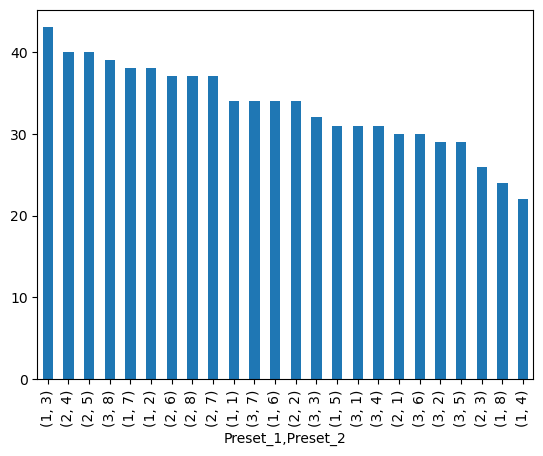

In [15]:
data[PRESETS].value_counts().plot(kind="bar")

In [16]:
data[TARGET].mean()

np.float64(0.0825)

- Columns are full filled without any nulls. 
- The rate of failure is approximately 8%
- Preset_1 (3) and Preset_2 (8) has 24 possible combinations
- Total of rows: 800
- The size of each combination varying and it is not uniform 

### Univariate Analysis 

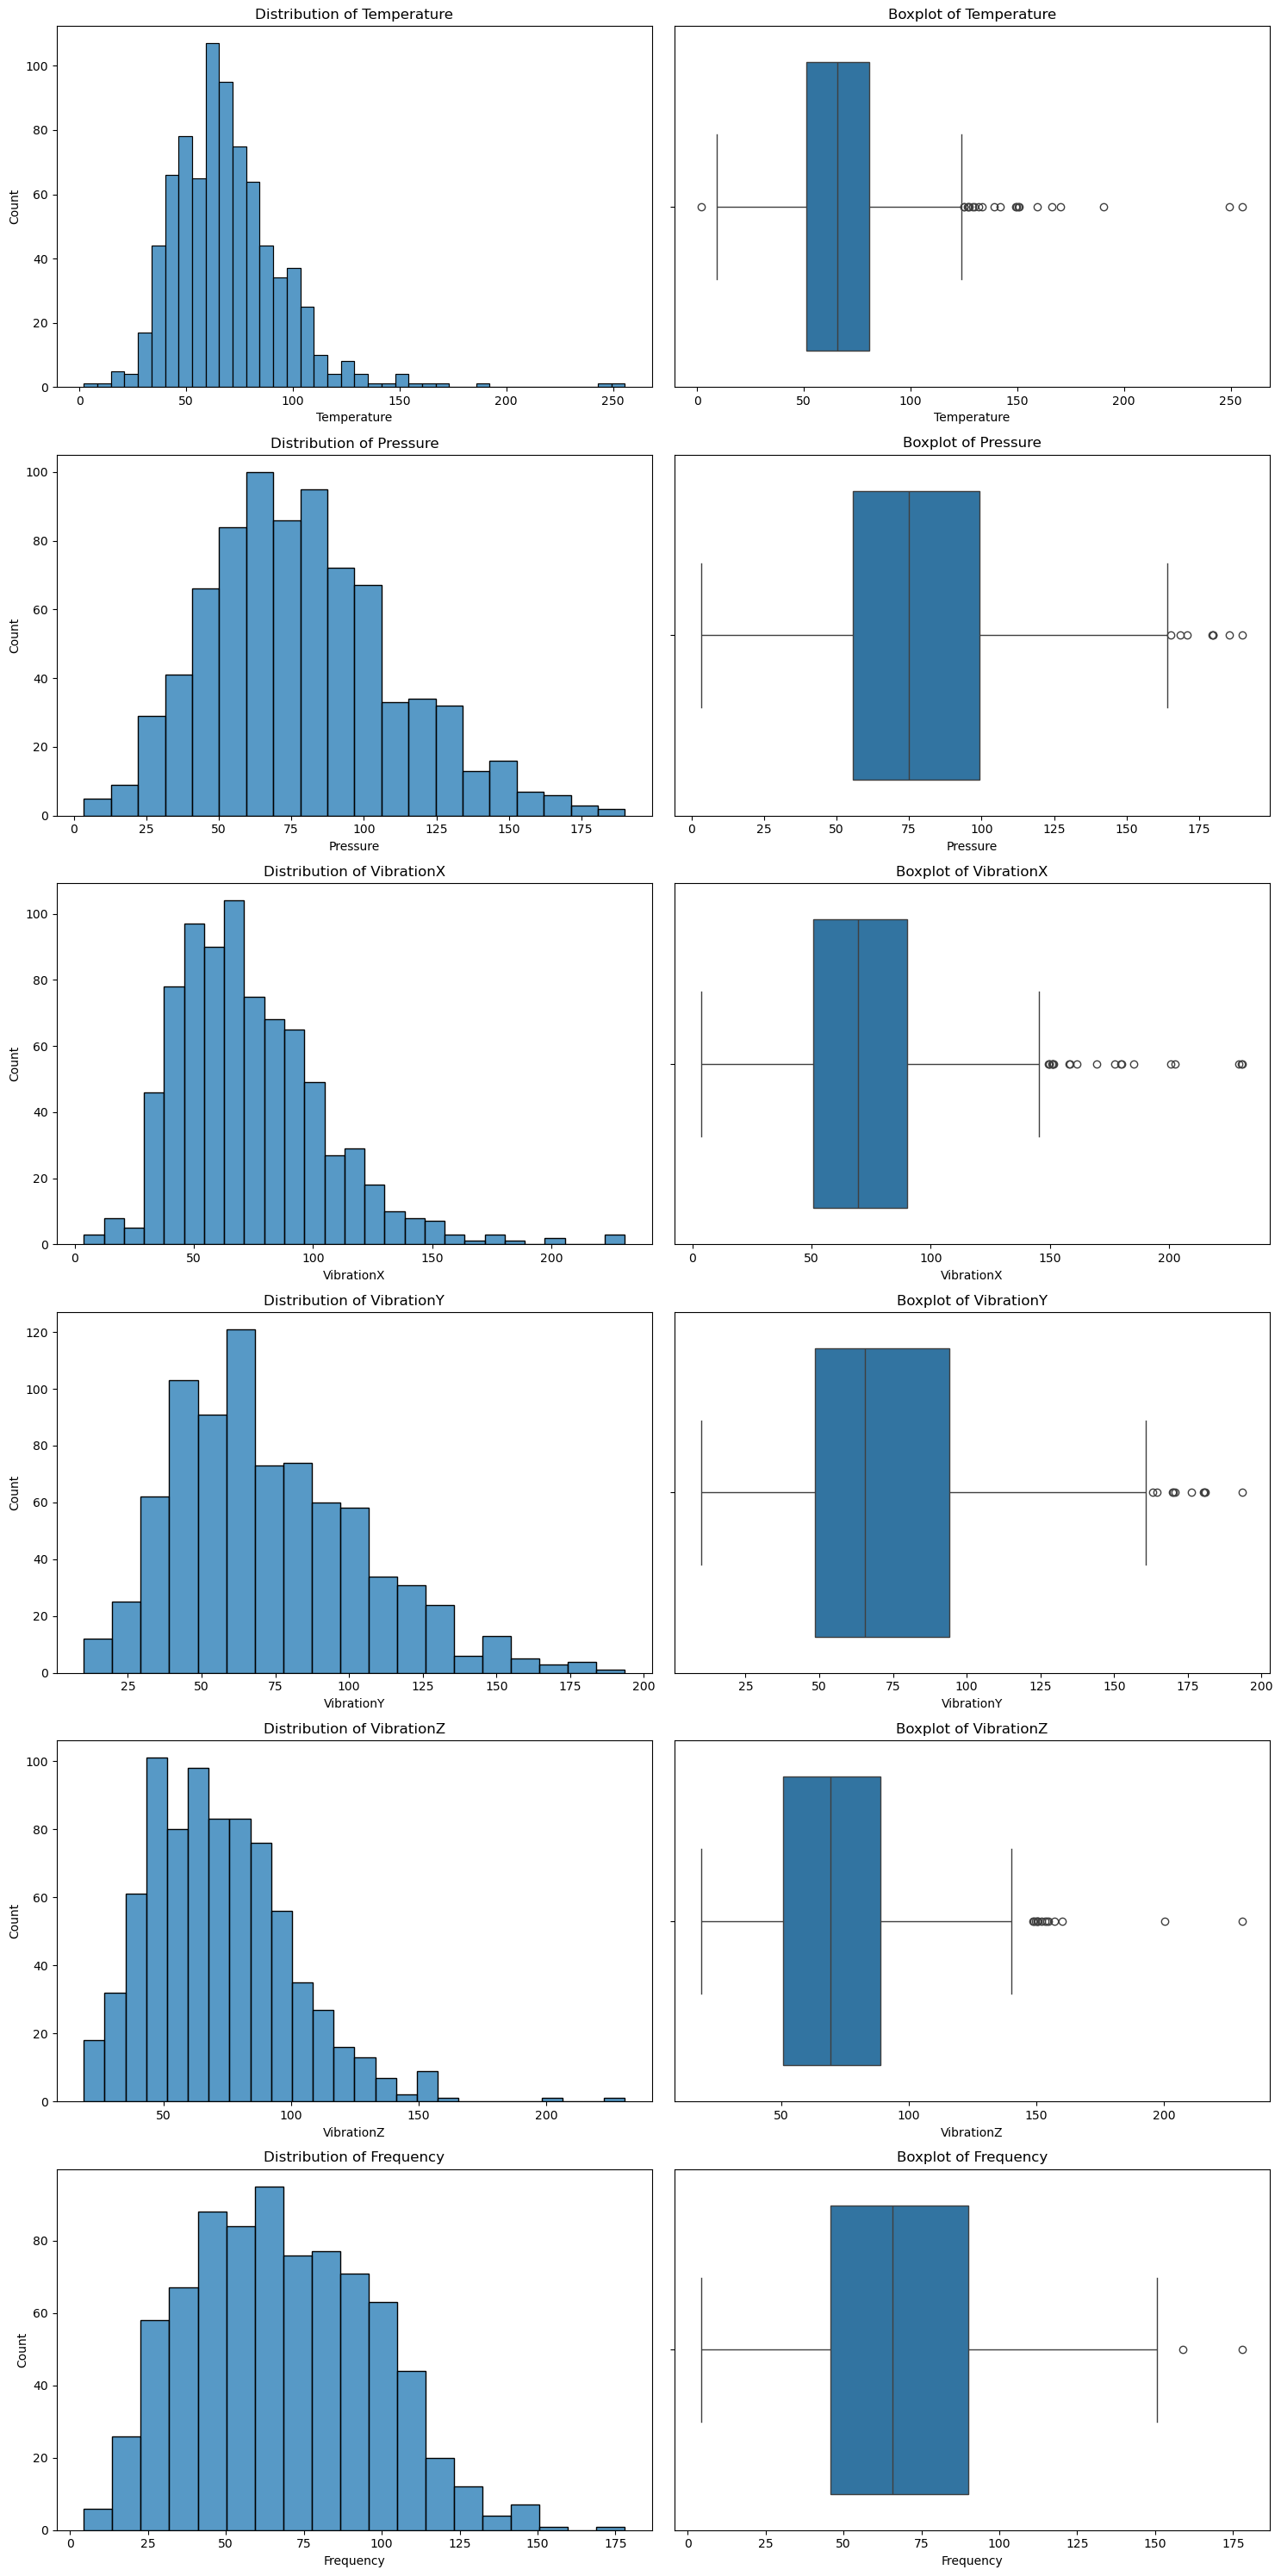

In [17]:
# Calculate the distribution of each one of raw features. See how much of feature is incorporing outliers on its distribution
total_features = len(FEATURES)

fig, axs = plt.subplots(nrows=total_features, ncols=2, figsize=(15, 30))

axs = axs.flatten()

for index, feature in enumerate(FEATURES):
    sns.histplot(data=data, x=feature, ax=axs[index * 2])
    axs[index * 2].set_title(f"Distribution of {feature}")

    sns.boxplot(data=data, x=feature, ax=axs[index * 2 + 1])
    axs[index * 2 + 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

- Frequency exhibits the fewest outliers, while Temperature and Vibration X show a significantly higher prevalence of anomalies.
- Most features approximate a normal (bell-shaped) distribution, though Vibration Y displays the highest variability, with its boxplot whiskers extending markedly farther than those of Z and X.
- No left-skewed outliers are present in the dataset, indicating symmetry in the lower tails across all distributions.

### Bivariate Analysis 

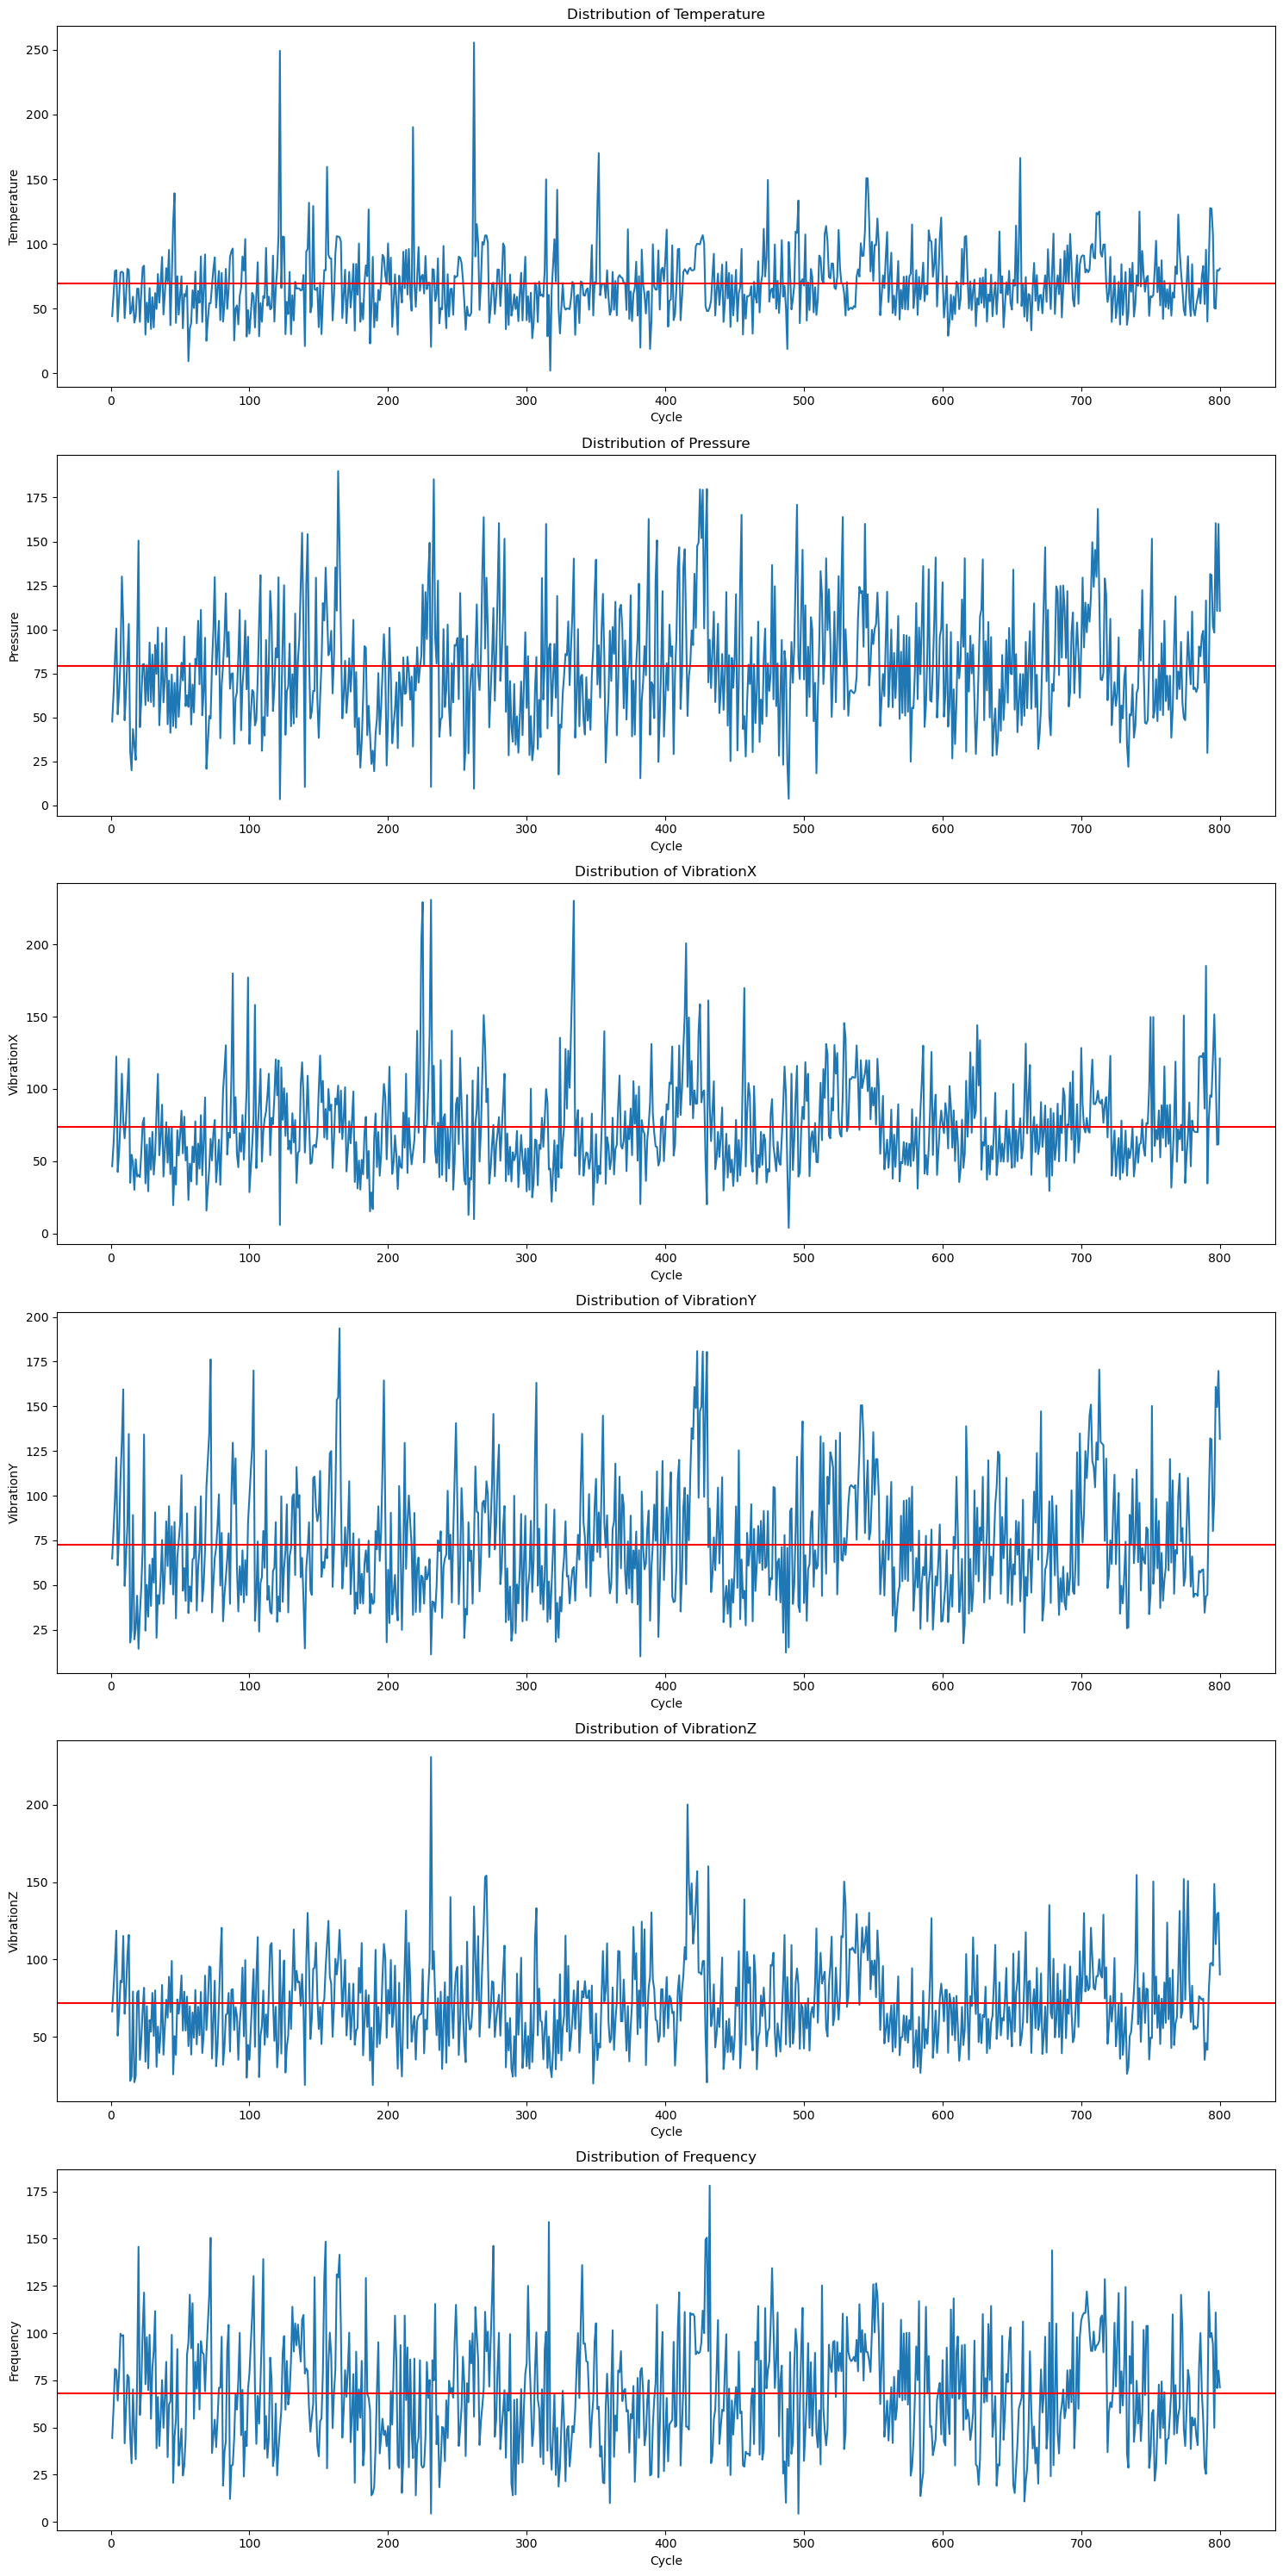

In [18]:
# Calculate a line plot to see if we have any kind of seasonal or trend features on data. In addition, we can analyze with the mean 
# and see if the time-series is around its mean value or not.
fig, axs = plt.subplots(nrows=total_features, ncols=1, figsize=(15, 30))

axs = axs.flatten()

for index, feature in enumerate(FEATURES):
    sns.lineplot(data=data, x=TIMESTAMP, y=feature, ax=axs[index])
    axs[index].set_title(f"Distribution of {feature}")
    # Add average line
    avg_value = data[feature].mean()
    axs[index].axhline(avg_value, color='red', linestyle='-', label='Average')

plt.tight_layout()
plt.show()


- All variables have some peaks. All six signals show intermettend bursts well above their typical band
- All timeseries is close to the its mean value
- Many of the large vibration spikes line up with spikes in the frequency, temperature, and pressure -> Probably unstable operation or high load
- The amplitude of most sensors get noisier after cycle 400 - 450 and again after 700

<Axes: xlabel='Preset_1,Preset_2'>

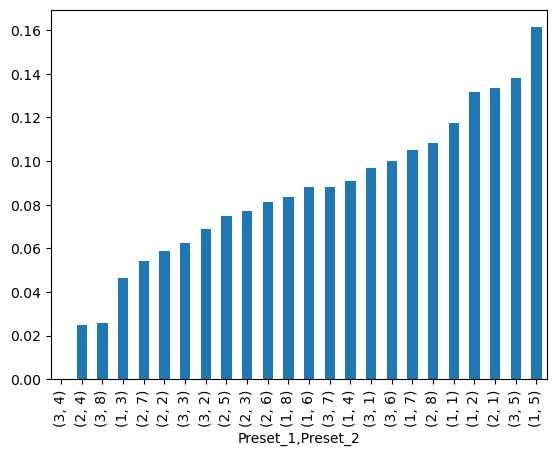

In [19]:
# Calculate the average fail per preset combination 
data.groupby(PRESETS)[TARGET].mean().sort_values().plot(kind='bar')

- Distribution of fail based on combinations of presets is not uniform
- Some combinations of presets like (1,5) has high chance to fail when in operation (16%). In contrast, combination (3,4) almost does not fail.
- Preset_1 (1) appears 4 times on the top 6 regarding failure average for the combinations. Maybe Preset_1 (1) is a operation with high frequency and temperature.
- A single "one-size-fits-all" maintenance policy is sub-optimal. Probably we have to take into account the average cost and the amount of time used to fix each combination to have a better solution.

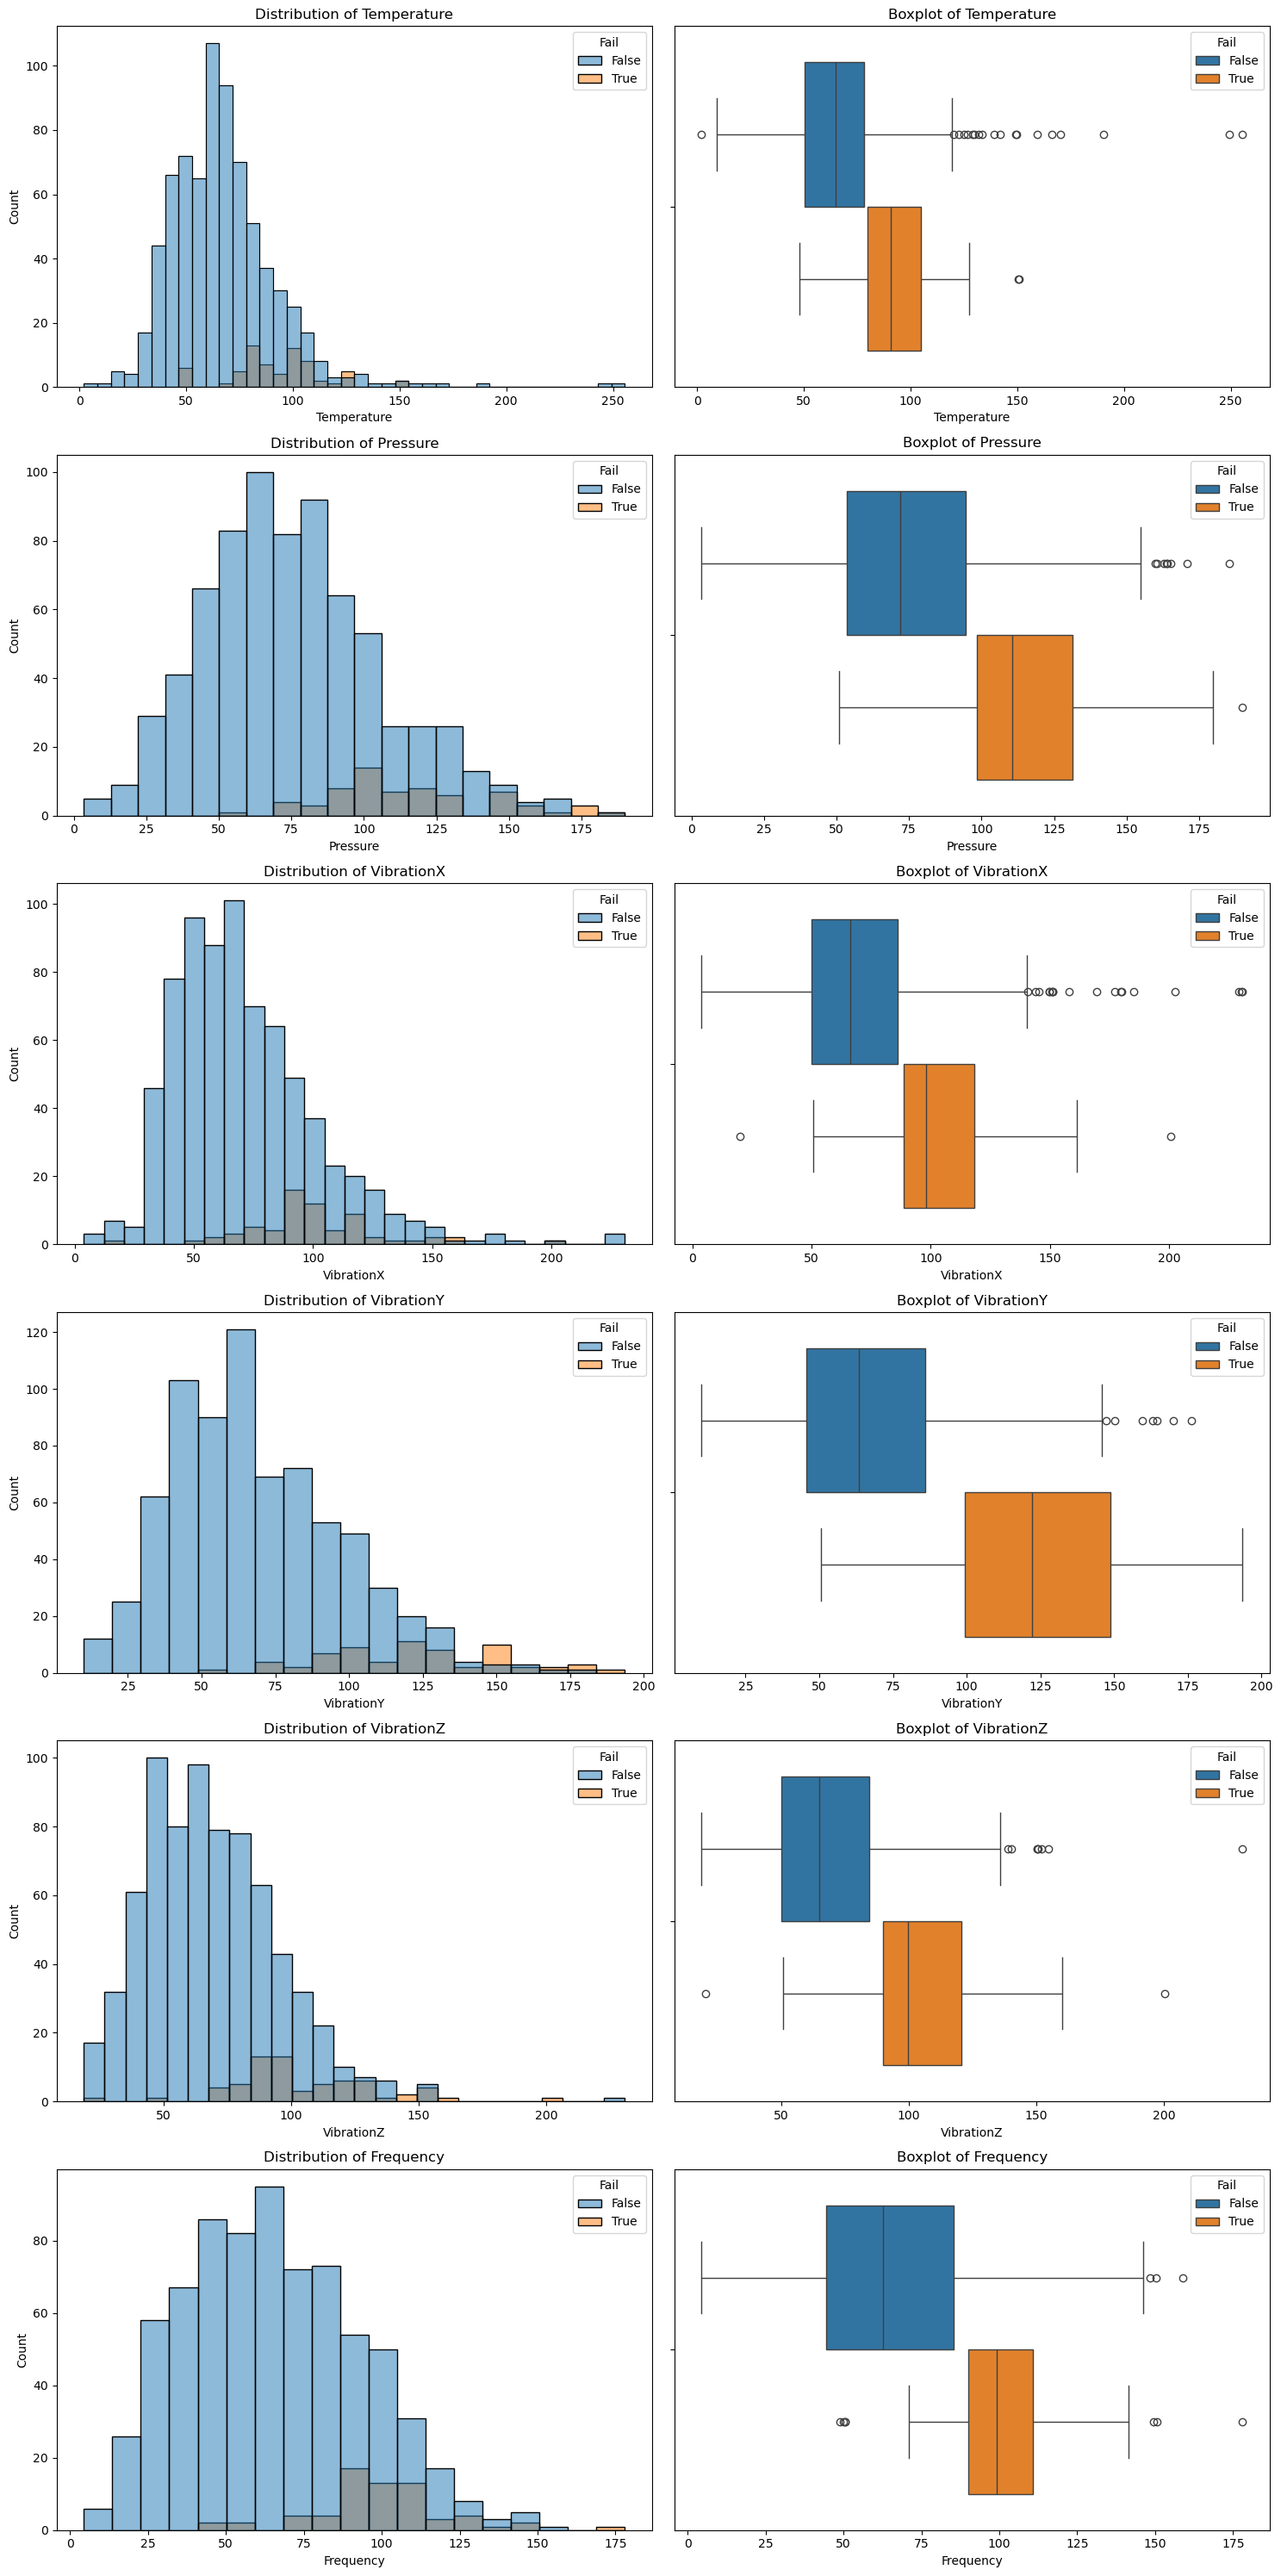

In [20]:
# Calculate the distribution of raw features but divided per label 
total_features = len(FEATURES)

fig, axs = plt.subplots(nrows=total_features, ncols=2, figsize=(15, 30))

axs = axs.flatten()

for index, feature in enumerate(FEATURES):
    sns.histplot(data=data, x=feature, ax=axs[index * 2], hue=TARGET)
    axs[index * 2].set_title(f"Distribution of {feature}")

    sns.boxplot(data=data, x=feature, ax=axs[index * 2 + 1], hue=TARGET)
    axs[index * 2 + 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

- Boxplots above show that are a clear division between fail or not fail regarding the distribution of the columns
- When target fail is True, most of the columns have high values when compared to False
- The most separeted data distribution between True and False is VibrationY
- All six variables spike well before failure.

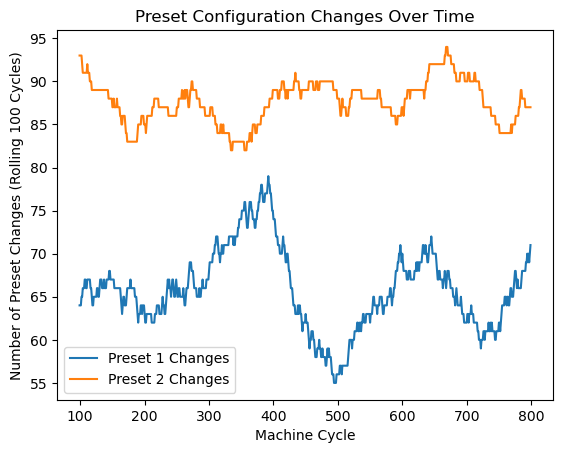

In [21]:
# Calculate preset change over time. If two lines have different presets we count this as preset change if not it is continuity. 
# In that way we can calculate how many time the presets change over a specific time windows 
data['preset_1_change'] = (data['Preset_1'] != data['Preset_1'].shift(1)).astype(int)
data['preset_2_change'] = (data['Preset_2'] != data['Preset_2'].shift(1)).astype(int)
data['preset_1_change'].rolling(100).sum().plot(label='Preset 1 Changes')
data['preset_2_change'].rolling(100).sum().plot(label='Preset 2 Changes')

plt.xlabel('Machine Cycle')
plt.ylabel('Number of Preset Changes (Rolling 100 Cycles)')
plt.title('Preset Configuration Changes Over Time')
plt.legend()  

plt.show()

- Preset 1 seems more constant related to changes, on the other hand, preset 2 is more volately, it is almost change every row.
- Between 330 and 380 Preset 1 has a peak, probably a fine tuning regarding the operations then it happens again between 500 and 600.
- After the fine tunning probably it has maitanence time with the collpase

<Axes: >

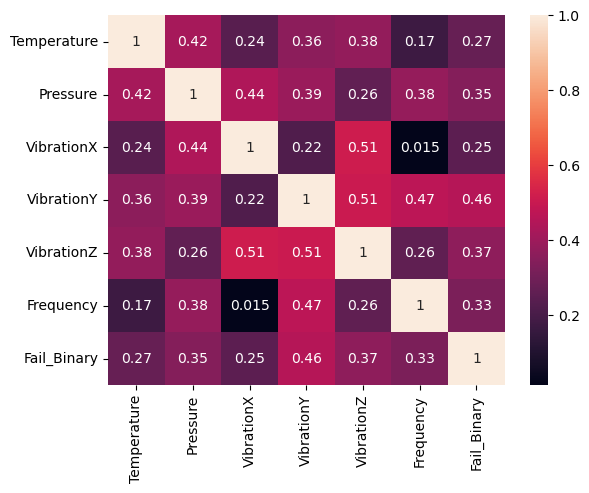

In [22]:
# Correlation between raw features and label. 
data['Fail_Binary'] = data[TARGET].astype(int)
sns.heatmap(data[FEATURES + ['Fail_Binary']].corr(),annot=True)

- Vibration Y has the highest correlation with the Target column (Fail_Binary)
- The cluster vibration shows a moderate force correlation between them
- Pressure correlates more with other variables in general (mechanical and thermal influence)
- Vibration Y has a moderate influence on Frequency, in contrast, VibrationX has almost zero influence on Frequency 

### Multi Variate Analysis 

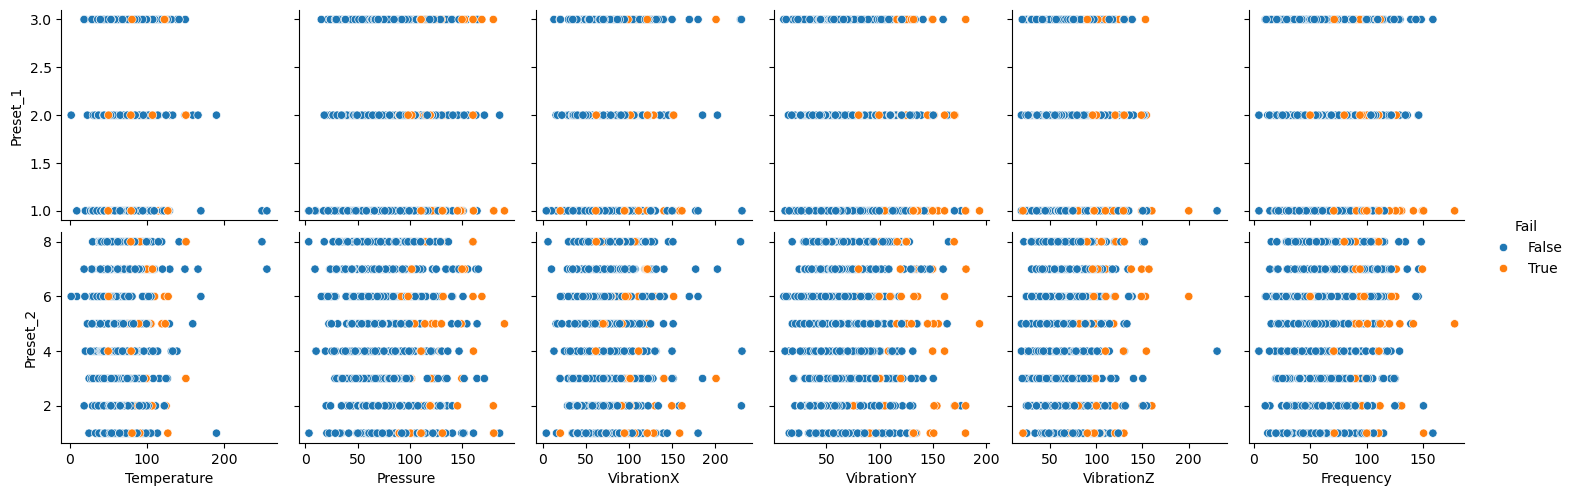

In [23]:
sns.pairplot(data,x_vars=FEATURES,y_vars=PRESETS, hue=TARGET)

- The plot reveals a consistent correlation between elevated feature values and failure events (Fail=True) across all presets.
- In contrast, Preset_1 (3) and Preset_2 (4), which exhibit near-zero failure rates, maintain the lowest observed maximum values for Frequency and Temperature, aligning with their reduced risk profile.

## Modelling 

### Feature Engineering

- Here is the creation of feature engineering. For this project 4 types of features were created to feed the model:
    - Rolling features: This features create a statistical analysis (mean, std, var) inside a specific windows size.
    - Lag Features: Capture peak values in a specific past timestamp
    - Vibration Magnitude Feature: Calculate vibration magnitude feature using the following formula: sqrt(x² + y² + z²)
    - Time-aware target encoding: Create a target encoding for preset but using time as auxiliary to avoid data leakage. Only calculate the mean value of the targe using the predecessor rows (t-1) for the row (t)

In [24]:
data = data.sort_values(TIMESTAMP)
data = create_features(data, PRESET_LAG)
data.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,...,Frequency_lag_2_by_Preset_2,Frequency_lag_3,Frequency_lag_3_by_Preset_1,Frequency_lag_3_by_Preset_2,Frequency_lag_5,Frequency_lag_5_by_Preset_1,Frequency_lag_5_by_Preset_2,Preset_1_target_encoded,Preset_2_target_encoded,Vibration_Magnitude
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.801329
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,130.232621
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.500000,161.994313
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False,...,NaN,44.483250,NaN,NaN,NaN,NaN,NaN,0.0,0.333333,209.236814
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False,...,NaN,60.228715,60.228715,NaN,NaN,NaN,NaN,0.0,0.250000,90.029176


### Target

- Construct a binary target column flagging failure risk C cycles ahead (forecasting horizon), enabling proactive maintenance scheduling. The paramter C, defined at the notebook initial cells, represents the desired lead time before maintenance and directly trade off early warning capability with prediction reliability


In [25]:
data[FUTURE_TARGET] = data[TARGET].shift(-C)
data.dropna(subset=[FUTURE_TARGET], inplace=True)
data[FUTURE_TARGET + "_binary"] = data[FUTURE_TARGET].astype(int)

### Selecting Columns

- Selecting features to retain only relevant columns for model training
- Split the dataset into features (X) and the target label (Y), establishing the inputs and outputs for classification approach

In [26]:
columns = data.columns.tolist()
columns.remove(TIMESTAMP)
columns.remove(TARGET)
columns.remove(FUTURE_TARGET)
columns.remove(FUTURE_TARGET + '_binary')
columns.remove('Preset_1')
columns.remove('Preset_2')
columns.remove('preset_1_change')
columns.remove('preset_2_change')
columns.remove('Fail_Binary')

In [27]:
X = data[columns] 
Y = data[[FUTURE_TARGET + "_binary"]]

### Hyperparamters Optimization 

- Optuna is library to search the best model hyperparameters
- It runs for N trials and use bayesian optimization to search the solution space
- Using PR-AUC to search the best hyperpameter for the model

In [28]:
study = optuna.create_study(direction='maximize', study_name='LGBM Classifier')
func = lambda trial: objective_lgb_optuna(trial, X, Y, TEST_SIZE, EARLY_STOPPING)
study.optimize(func, n_trials=N_TRIALS,show_progress_bar=True)

  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's average_precision: 0.468822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's average_precision: 0.487516
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's average_precision: 0.533811
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's average_precision: 0.497189
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's average_precision: 0.523366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's average_precision: 0.486796
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's average_precision: 0.497241
Training until valida

In [29]:
print(f"Best value (pr-auc): {study.best_value:.5f}")

Best value (pr-auc): 0.70559


In [30]:
parameters = {**DEFAULT_LGB_PARAMETERS, **(study.best_params or {})}

### Train/Test

- Using the DEFAULT_LGB_PARAMETERS and the best parametes found on the optuna hyperparameter search it will train a new model
- The new model will be used to calculate the feature importance and inference time

In [31]:
 model, test_preds, x_train, y_train, x_test, y_test, metrics_dict = lgb_train_test(X, Y, params=parameters, 
                                                                                         test_size=TEST_SIZE, threshold=THRESHOLD)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's average_precision: 0.705593


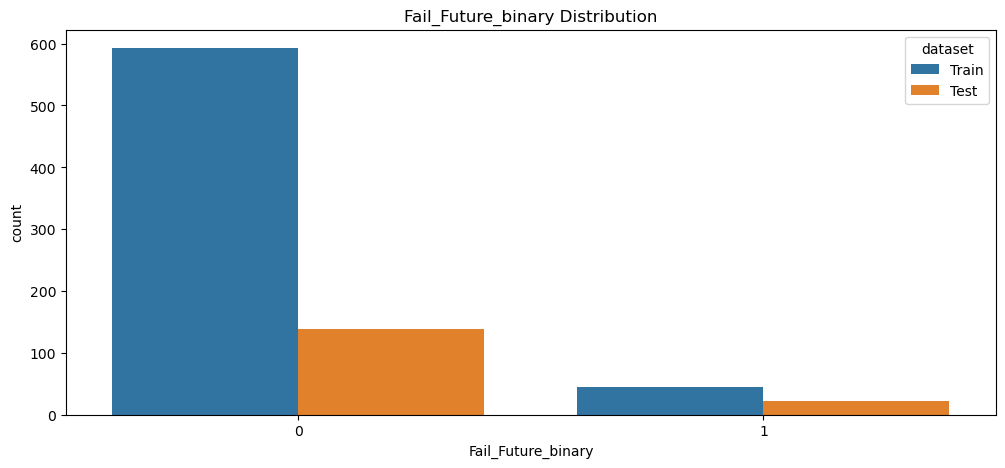

In [32]:
plot_count(y_train, y_test, FUTURE_TARGET +  '_binary')

- Plot above shows count the number of positive/negative examples for train/test datasets
- Test dataset has almost half of positive class points when compared to train dataset

In [33]:
# Getting presets using row index 
x_train_presets = x_train.join(data[['Preset_1', 'Preset_2']])
x_test_presets = x_test.join(data[['Preset_1', 'Preset_2']])

x_train_presets['Preset_1'] = x_train_presets['Preset_1'].astype(str)
x_train_presets['Preset_2'] = x_train_presets['Preset_2'].astype(str)
x_test_presets['Preset_1'] = x_test_presets['Preset_1'].astype(str)
x_test_presets['Preset_2'] = x_test_presets['Preset_2'].astype(str)

# Combining presets on the train and test dataset 
x_train_presets['Presets'] = x_train_presets['Preset_1'] +  '_' + x_train_presets['Preset_2']
x_test_presets['Presets'] = x_test_presets['Preset_1'] +  '_' + x_test_presets['Preset_2']

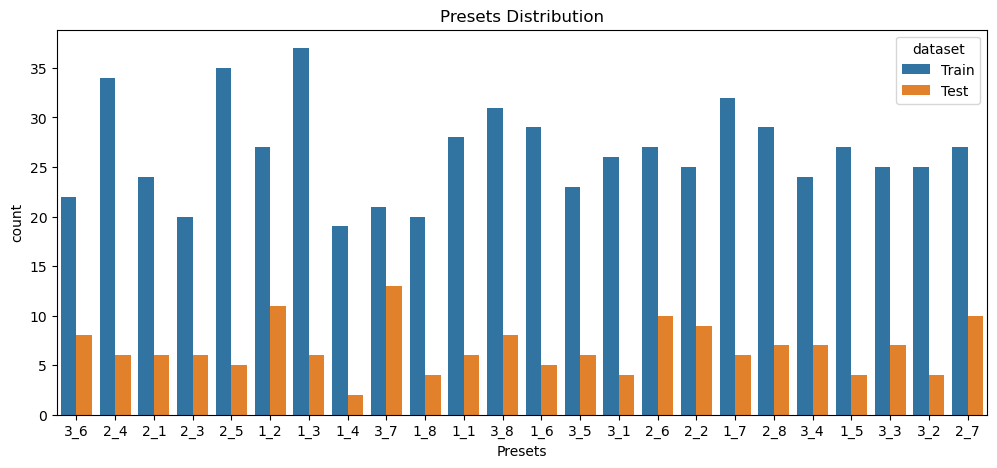

In [34]:
plot_count(x_train_presets, x_test_presets, 'Presets')

- The train and test datasets exhaustively include all combinations of presets (Preset_1 + Preset_2), preventing unseen setting configurations in production. This ensures model robustness by eliminating gaps between validated and unvalidated operational scenarios

### Inference Time

In [35]:
test_model_inference_time(len(columns), BATCH_INFERENCE_SIZE)

Average time per batch (10000 samples): 0.003715 seconds
Average time per sample: 0.000000 seconds


- Model has inference time that is approximately 1ms per sample. 

## Metrics  

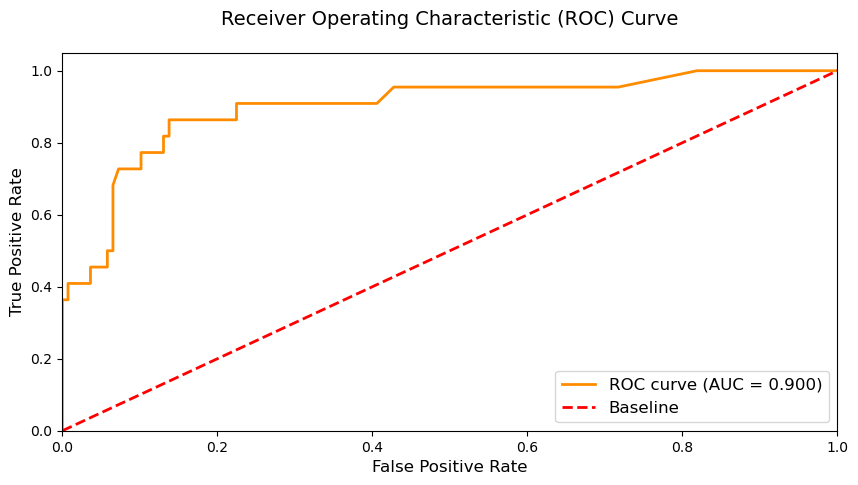

In [36]:
# Calculate roc curve 
plot_roc_with_auc(metrics_dict)

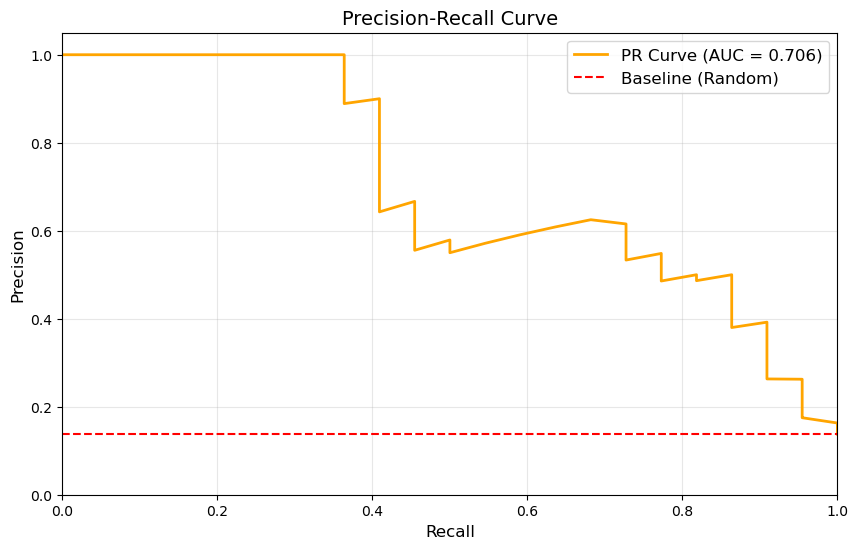

In [37]:
# Calculate pr curve
plot_pr_curve(metrics_dict, y_test)

- PR-AUC evaluates model performance across all classification thresholds (e.g., maintenance is recommended if the model's output exceeds the threshold), enabling adjustment of the threshold to balance false positives/negatives and optimize true positives/negatives. The baseline is derived from the proportion of positive class instances (e.g., failures) in the test dataset, representing a 'no-skill' classifier.


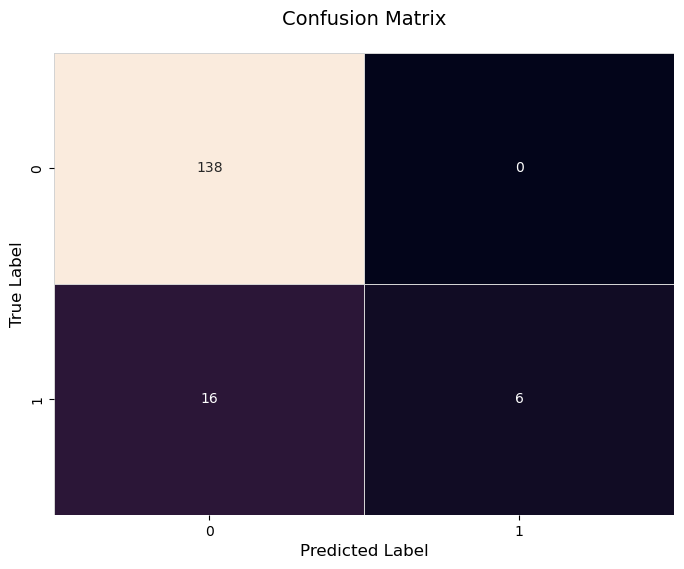

In [38]:
# Calculate confusion matrix 
plot_confusion_matrix(metrics_dict)

- PR-AUC Selection
    - It was chosen to address dataset imbalance (low failure rate) and prioritize minimizing false negative, which are costlier for maintenance decisions. Threshold tuning allows us to control the FN/FP tradeoff.
- Confusion Matrix
    - The models higher false negative rates compared to false positives, indicating grater risk of missing critical failures. But we can tuning threshold better to have less false negative
- C results (PR-AUC)
    - C = 3: 0.71
    - C = 5: 0.61
    - C = 10: 0.39
- LightGBM
    - This model was selected because it balances high predictive accuracy with computational efficiency, enabling rapid training and low-latency inference - critical for real-time applications with strict cycle-time requirements

## Explanation

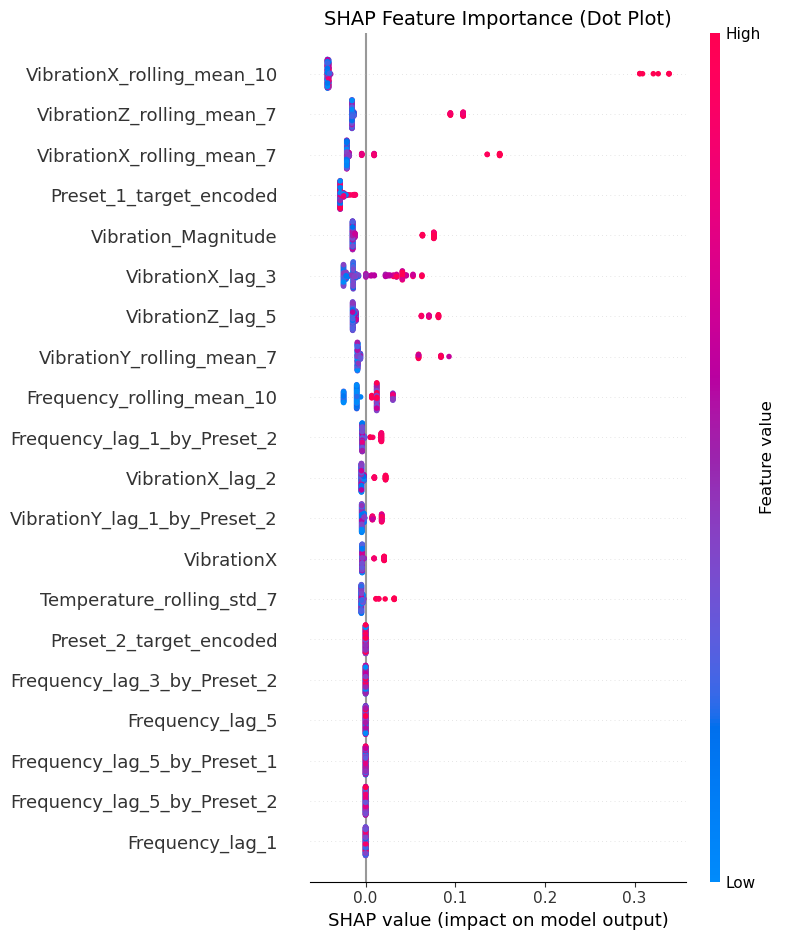

In [39]:
# Calculate shap summary plot
shap_values = shap_explainer(model, x_test, len(x_test))

SHAP Model (Explanation: High feature values (red) increase failure risk when on the right of 0.0, while low values (blue) on the left reduce risk by pushing predictions toward non-failure.)

- High recent virbration levels increase failure risk. Low vibration values pull the predction away from failure
- High average X-axis vibration in the last 10 cycles strongly reaises failure risk.
- Preset combinations push prediction to not fail, but high values push less than low values
- If vibration stay high for 7-10 cycles, risk keeps climbing.
- Vibration magnitude shows that high values of vibrations for all axis can push the prediction to failure
- High frequency push to failure. Frequency is associate with vibration X given the correlation plot, so more frequency causes more vibration probably
- Spike of vibration 3/5 cycles ago increases the prediction, but not as dramatically as the rolling means.
- Temperature variability over 7 cycles is a risk amplifier (Stable temps are safer). Temperature spikes also increase risk for maitanence
------------------------------------------------
- What his means operationally:
    - Focus on vibration monitoring - especially x-axis rolling means
    - Create alert thresholds
        - A spike rule: the 3/5-cycle vibration above certain value on axis x triggers maintenance
        - A sustained rule: 7-cycle/10-cycle rolling mean above certain value on axis x triggers maintenance
            - Same for 7-cycle regarding Z
    - Cross check presets, certain presets have high failure risk

## Future Improvements 

- Use a cross-validation time-split to get a more robust model preserving temporal order and avoid leakage
- Use a undersampling/oversampling approach to balance datastet while preserving critical failure patterns. Alternatively, use class weight to penalize misclassification of the minority
- Try different types of models like (Random Forest, TreeDecision, XGBoost, CatBoost, ARIMA or LSTM)
- Add isotonic calibration above model output, so in that way model outputs probabilities (e.g, 80% score = 80% failure likelihood)
    - High risk scores related to fail can be prioritize and low risk can be postpone
- Add feature selection procedure using backward selection (Remove features until maximum accepted decreasing of the performance is reached) and shap feature importance

## Deploy and Production

#### Deployment Architecture
- Containerize the model: Package the model and its dependecies into a leightweight docker container using multis-tage build process to minimize image size and security vulnerabilities.
- API Development: Develop a RESTFul API using FastAPI, leverging its asynchronous capabilities. Implement an endpoint (/predict) that accepts sensor data in JSON format via POST requests, validate inputs schemas with Pydantic, and returns model predictions with confidence scores
- Cloud Deployment: Deploy the dockerized API on AWS EC2. Slack Integration: Integrate the API with Slack's Incoming Webhooks to send real-time alerts to a dedicated channels when the predictions exceed a configurable risk threshold.
Maintenance Workflow: Configure alerts to trigger maintenance tickets in the operationl team's workflow tools.

#### Robust System
- Peformer end-to-end monitoring
    - Performacne Metrics: PR-AUC, precision ,recall
    - Data/Concept Drift: Use statistical tests (KS), averages and percentiles to monitore features
    - Infrastructure: Monitor API latency, error lates, and ec2 cpu/memory usage
- Retraining Pipeline:
    - Trigger: Retrain when performance drops below a threshold or montlhy
    - Validation: Use time-based cross validation to avoid leakage
    - Canary Deployment: A/B test new models in shadow mode before replacing the production

#### Operational Team Training
- Train the team to interpret prediction scores
- Allow querying predictions directly from Slack
- Conduct failure scenario simulations to refine response protocols